# Energy scenario design in Aalborg

Author: Michele Urbani ([murbani@fbk.eu](mailto:murbani@fbk.eu))
Date: 15th October, 2024

The research presented in {cite:p}`MAHBUB2016140` is replicated here to
showcase the functionality of the MOEA package.

MOEA is based on [PyMOO](https://pymoo.org/) for the implementation of the multi-objective
evolutionary algorithm and on EnergyPLAN for the energy scenario modeling.

PyMOO breaks down multi-objective optimization into the following steps.

1. **Model description**: the optimization models must be encoded in a PyMOO
``Problem`` class, or one of its subclasses ``ElementwiseProblem``, etc.

    1. The ``Problem`` class required to declare a set of high level problem
    information, such as the number of variables, objective, inequality
    constraints, and equality constraints.
    2. The objective function evaluation procedure, which in our case calls
    EnergyPLAN to resolve the instances defined by the solutions found by the
    algorithm. The output values are then read, and eventually postprocessed,
    and provided to the algorithm together with constraint violations.

2. **Algorithm declaration**: in this case the standard NSGA-II is used.
3. **Resolution**: the utility function ``minimize`` is used to optimize the
problem. 

## Problem declaration

The words problem and model are use interchangeably here.
In the following, the Aalborg model is explained in details to show an example
of problem declarations.
To avoid declaring the model twice, the class is declared in
``moea.models.aalborg.AalborgA`` and the code is print here with further
comments.

In [1]:
import inspect
from IPython.display import display, Markdown

from moea.models import get_model
from moea.algorithms import get_algorithm

model_name = 'AalborgA'
algorithm_name = 'NSGA-II'

model = get_model(model_name)
algorithm = get_algorithm(algorithm_name, pop_size=100)

2024-10-23 15:26:02.888 | INFO     | moea.config:<module>:11 - PROJ_ROOT path is: C:\Users\Urbani\moea


The following cell shows the code used for initializing the model.

The only parameter that can be provided is ``data_file``, i.e., the path to the
default EnergyPLAN input data. The default value for this variable is already
set to ensure reproducibility of the research.

Input variables are defined as a pandas DataFrame: each row corresponds to a
variable, whose index is the variable name in EnergyPLAN, and the columns
``lb`` and ``ub`` correspond to the lower and upper bound of the variable,
respectively.

Later, the parent class is initialized with ``super().__init__()``. This method
requires problem infomation, such as the number of variables, the number of
(in)equality constraints, the number of objectives, and the upper and lower
bounds.
Decision variable are assumed to be real numbers.

Even though it is not visible in the code below, the class inherits from the
``moea.models.base_model.BaseModel`` class.

In [2]:
# Print models class __init__ code
init_code = inspect.getsource(model.__init__)
display(Markdown("```python\n" + init_code + "```"))

```python
    def __init__(self,
                 data_file: Union[str, Path] = "Aalborg2050_2objectives.txt",
                 **kwargs):
        """
        Parameters:
        -----------
        - ``data_file``: str or Path

            The path to the input file. This file is used as a template to
            generate the input files for each individual.
            The values will be replaced by the values of the decision variables
            when generating the input files.
        """
        # Define the input variables.
        self.vars = pd.DataFrame.from_dict({
            'input_cap_chp3_el': {'lb':0, 'ub': 1000},
            'input_cap_hp3_el': {'lb':0, 'ub': 1000},
            'input_cap_pp_el': {'lb': 0, 'ub': 1000},
            'input_RES1_capacity': {'lb': 0, 'ub': 1500},
            'input_RES2_capacity': {'lb': 0, 'ub': 1500},
            'input_RES3_capacity': {'lb': 0, 'ub': 1500},
            'input_cap_boiler3_th': {'lb': 0, 'ub': 10000},
        }, dtype=float, orient='index')

        # Initialize the parent class
        super().__init__(
            n_var=len(self.vars),
            n_ieq_constr=3,
            n_obj=2,
            xl=self.vars['lb'].values,
            xu=self.vars['ub'].values,
            data_file=data_file,
            **kwargs
        )
```

The evalutation method is the core of the objective function calculation.

The ``_evaluate`` method does not return a value but it expects you to set a
value for, at the least, the ``out["F"]`` value of the ``out`` dictionary.
This must be a numpy array, whos size is $N_{solutions} \times N_{objectives}$.

The dictionary values ``"G"`` and ``"H"`` can be used to declare the left-hand
side of inequalities and equalities constraints, respectively.
These arrays must have size $N_{solutoins} \times N_{constraints}$.

In [3]:
eval_code = inspect.getsource(model._evaluate)
display(Markdown("```python\n" + eval_code + "```"))

```python
    def _evaluate(self, x, out, *args, **kwargs):
        """
        This function defines the evaluation of the problem. That is, the
        objective function and constraints are evaluated here. The objective
        function evaluation consists of a call to EnergyPLAN. Since the problem
        is unconstrained, the constraints are not evaluated.

        """
        # Dump the full list of variables to a file
        for i, ind in enumerate(x):
            dump_input({k: ind[j] for j, k in enumerate(self.vars.index)}, i,
            self.default_data)

        # Call EnergyPLAN using spool mode; only the input files are needed
        execute_energyplan_spool([f"input{i}.txt" for i in range(len(x))])

        # The label for the monthly values
        montly_lbl = 'MONTHLY AVERAGE VALUES (MW)'

        # Parse the output file and store the objective function value in an
        # array
        out["F"] = find_values(
            ENERGYPLAN_RESULTS,
            "CO2-emission (corrected)",
            "TOTAL ANNUAL COSTS",
        )

        # CONSTRAINTS
        # Since there are a fes constraints, we evaluate the left-hand side
        # of the constraints and store the values in out["G"].

        # Read and store the values of interest into arrays
        import_elec, heat, stable_load = [], [], []
        for res in ENERGYPLAN_RESULTS.glob("*.txt"):
            # Parse the output file
            D = parse_output(res)
            # Results are organized as dictionary, one for each section, and
            # each value is a pandas DataFrame
            # Retrieve import
            import_elec.append(
                float(D[montly_lbl]['Import Electr.']['Annual Maximum']))
            # Retrieve Balance3 heat
            heat.append(
                float(D['TOTAL FOR ONE YEAR (TWh/year)']['Balance3  Heat']))
            # Retrieve stabilized load percentage
            stable_load.append(
                float(D[montly_lbl]['Stabil. Load']['Annual Minimum']))

        # Transmission line capacity of export/import: 160 MW. This constraint
        # enforces the system to produce enough electricity so that it does not
        # require to import more than 160 MW.
        import_constr = np.array(import_elec) - 160

        # Heat balance. This constraint enforces the system to produce exactly
        # the amount of heat necessary to meet the heat demand.
        heat = np.array(heat)

        # Grid stabilization: More than 30% of power production in all hours
        # must come from units able to supply grid support (see [77] for
        # details on grid stability in EnergyPLAN).
        # This constraint is already taken into account by EnergyPLAN so we
        # just need to subtract the value from 100 to have a constraint that
        # is satisfied when the value is positive.
        stable_load = 100 - np.array(stable_load)

        out["G"] = np.column_stack([
            import_constr,
            stable_load,
            heat,
        ])
```

## Problem resolution

The utility function ``minimize`` is the default way to run an algorithm on a
problem of your choice.
It requires to pass the model variable, i.e., the variable to which the model
has been assigned, the algorithm, and a stopping criterion.
Optionally, a ``seed`` value can be provided, which enables replicability of
results, and ``verbose`` can be set to ``True`` to visualize runtime infomrmation.

The ``minimize`` function returns an objects storing results. Below, we show
how to extract some quantities of interest and plot them.

In [4]:
from pymoo.optimize import minimize

res = minimize(
    model,
    algorithm,
    ('n_gen', 50),
    seed=4395,
    verbose=True
)

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      100 |     12 |  0.000000E+00 |  0.5497000000 |             - |             -
     2 |      200 |     14 |  0.000000E+00 |  0.0026000000 |  0.0373133166 |             f
     3 |      300 |     12 |  0.000000E+00 |  0.000000E+00 |  0.0238515901 |         ideal
     4 |      400 |     17 |  0.000000E+00 |  0.000000E+00 |  0.0070422535 |         ideal
     5 |      500 |     19 |  0.000000E+00 |  0.000000E+00 |  0.0048851132 |             f
     6 |      600 |     23 |  0.000000E+00 |  0.000000E+00 |  0.0824548193 |         ideal
     7 |      700 |     24 |  0.000000E+00 |  0.000000E+00 |  0.0067314884 |         ideal
     8 |      800 |     24 |  0.000000E+00 |  0.000000E+00 |  0.0078904250 |             f
     9 |      900 |     26 |  0.000000E+00 |  0.000000E+00 |  0.0026748884 |             f
    10 |     1000 |     27 |  0.000000E+00 |  0.000000E+00 |  0.0108614232 |         ideal

## Results analysis

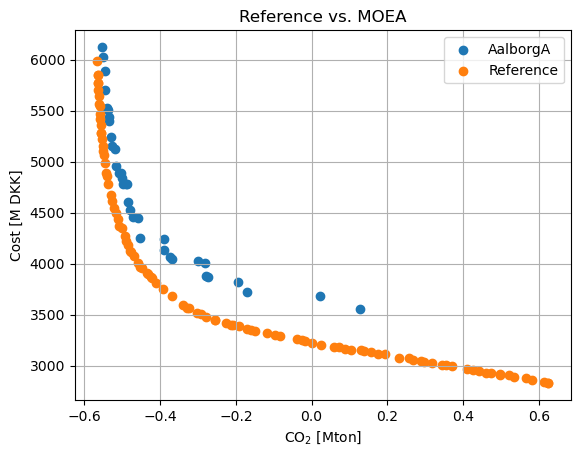

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Get the pareto-front
F = res.F

# Load reference data from the paper, no index column and space separated
ref = pd.read_csv('aalborg-reference.csv', sep=' ', header=None,
                  names=['CO2 [Mton]', 'Cost [M DKK]'],
                  index_col=False)

# Plot the pareto-front
plt.scatter(F[:,0], F[:,1], label='AalborgA')
plt.scatter(ref.values[:,0], ref.values[:,1], label='Reference')
plt.xlabel('CO$_2$ [Mton]')
plt.ylabel('Cost [M DKK]')
plt.title('Reference vs. MOEA')
plt.grid()
plt.legend()

plt.show()

### Convergence analysis

The results of the paper {cite:t}`MAHBUB2016140` are used as reference to
measure the quality of the solution. We implement the Inverted Generational
Distance (IGD) {cite:t}`COELLOCOELLO2004688` to quantify the distance from any
point in the set of solutions $Z$ to the closest point in the set of
reference solutions $A$.

$$
IGD(A) = \frac{1}{|Z|} \left( \sum_{i=1}^{|Z|} \hat{d}_i ^{\,p} \right) ^{1/p}
$$

where $\hat{d}_i$ represents the Euclidean distance ($p=2$) from $z_i$ to its
nearest reference point in $A$.

The lower the value of the IGD, the closer the set $A$ to the reference set
$Z$.

In [7]:
from pymoo.indicators.igd import IGD

ind = IGD(res.F)
print("IGD", ind(ref.values))

IGD 18.916666714105435


## References

```{bibliography}
:style: unsrt
```